In [1]:
import sys
import IPython
import numpy as np
import pandas as pd
import sklearn as sk

print ('Python version: %s.%s.%s' % sys.version_info[:3])
print ('IPython version:', IPython.__version__)
print ('numpy version:', np.__version__)
print ('pandas version:', pd.__version__)
print ('scikit-learn version:', sk.__version__)

Python version: 3.5.2
IPython version: 6.2.1
numpy version: 1.13.3
pandas version: 0.21.0
scikit-learn version: 0.19.1


In [2]:
#leyendo datos creados desde Rstudio
import feather
iris_df = feather.read_dataframe('../data/iris.feather')
iris_df.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
## Usando OneHotEncoder
from sklearn.preprocessing import LabelEncoder
#from sklearn.preprocessing import OneHotEncoder

#print(iris_df.head())
X = iris_df.iloc[:,0:4]
y = iris_df.iloc[:,4]

label_encoder = LabelEncoder()  ## Para convertir a enteros
#one_hot_encoder = OneHotEncoder()

## Convertirmos a enteros, i.e. setosa -> 0, etc
y = label_encoder.fit_transform(y)
print(y.shape)


(150,)


In [4]:
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2)

/home/farid/.pyenv/versions/3.5.2/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/farid/.pyenv/versions/3.5.2/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Magic Loop

[tutorial](http://www.codiply.com/blog/hyperparameter-grid-search-across-multiple-models-in-scikit-learn/)

*First  dictionary:* models to be scored <br>
*Second dictionary:* parameters for each model <br>
*Fit:* returns a paremeter grid search with cross validation for each model and for the given data <br>
*Score_summary:* returns a data_frame with a summary of the scores <br>

In [5]:
from sklearn.grid_search import GridSearchCV

class EstimatorSelectionHelper:
    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}
    
    def fit(self, X, y, cv=3, n_jobs=1, verbose=1, scoring=None, refit=True):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, 
                              params, 
                              cv=cv, 
                              n_jobs=n_jobs, 
                              verbose=verbose, 
                              scoring=scoring, 
                              refit=refit)
            gs.fit(X,y)
            self.grid_searches[key] = gs    
    
    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})
            #return pd.Series(dict(params.items() + d.items()))
                      
        rows = [row(k, gsc.cv_validation_scores, gsc.parameters) 
                for k in self.keys
                for gsc in self.grid_searches[k].grid_scores_]
        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        
        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        
        return df[columns]


In [10]:
from sklearn.ensemble import (ExtraTreesClassifier, RandomForestClassifier, 
                              AdaBoostClassifier, GradientBoostingClassifier)
from sklearn.svm import SVC
from sklearn.linear_model import  LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

models1 = { 
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'LogisticRegression' : LogisticRegression(),
    'KNeighborsClassifier' : KNeighborsClassifier(),
    'NaiveBayes': MultinomialNB(),
    ''
    'SVC': SVC()
}

params1 = { 
    'ExtraTreesClassifier': { 'n_estimators': [16, 32] },
    'RandomForestClassifier': { 'n_estimators': [16, 32], 'max_depth': [1,5, 10], 'max_features':['sqrt', 'log2'], 'min_samples_split': [2,5,10] },
    'AdaBoostClassifier':  { 'n_estimators': [16, 32] },
    'GradientBoostingClassifier': { 'n_estimators': [16, 32], 'learning_rate': [0.8, 1.0] },
    'LogisticRegression' : { 'C' : [1, 1e3, 1e5] },
    'KNeighborsClassifier' : { 'n_neighbors' : [3,5] },
    'NaiveBayes' : { 'alpha' : [0.1, 0.001, 0.0001] },
    'SVC': [
        {'kernel': ['linear'], 'C': [1, 10, 100]},
        {'kernel': ['rbf'], 'C': [1, 10, 100], 'gamma': [0.001, 0.0001]},
    ]
}


In [11]:
helper1 = EstimatorSelectionHelper(models1, params1)
%time helper1.fit(X_train, y_train, scoring='accuracy', n_jobs=-1)

Running GridSearchCV for GradientBoostingClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.5s finished


Running GridSearchCV for SVC.
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Running GridSearchCV for ExtraTreesClassifier.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.1s finished


Running GridSearchCV for KNeighborsClassifier.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s finished


Running GridSearchCV for LogisticRegression.
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.1s finished


Running GridSearchCV for AdaBoostClassifier.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s finished


Running GridSearchCV for RandomForestClassifier.
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    4.1s finished


Running GridSearchCV for NaiveBayes.
Fitting 3 folds for each of 3 candidates, totalling 9 fits
CPU times: user 1.85 s, sys: 460 ms, total: 2.31 s
Wall time: 7.73 s


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.1s finished


In [12]:
helper1.score_summary(sort_by='min_score')

,estimator,min_score,mean_score,max_score,std_score,C,alpha,gamma,kernel,learning_rate,max_depth,max_features,min_samples_split,n_estimators,n_neighbors
17,LogisticRegression,0.95,0.958526,0.974359,0.0112066,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,GradientBoostingClassifier,0.948718,0.958109,0.97561,0.0123858,NaN,NaN,NaN,NaN,0.8,NaN,NaN,NaN,16,NaN
22,RandomForestClassifier,0.948718,0.958109,0.97561,0.0123858,NaN,NaN,NaN,NaN,NaN,1,sqrt,2,16,NaN
18,LogisticRegression,0.948718,0.958109,0.97561,0.0123858,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,RandomForestClassifier,0.948718,0.958109,0.97561,0.0123858,NaN,NaN,NaN,NaN,NaN,10,sqrt,10,32,NaN
15,KNeighborsClassifier,0.948718,0.966443,0.97561,0.0125357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
50,RandomForestClassifier,0.948718,0.958109,0.97561,0.0123858,NaN,NaN,NaN,NaN,NaN,10,sqrt,10,16,NaN
1,GradientBoostingClassifier,0.948718,0.966443,0.97561,0.0125357,NaN,NaN,NaN,NaN,0.8,NaN,NaN,NaN,32,NaN
49,RandomForestClassifier,0.948718,0.966443,0.97561,0.0125357,NaN,NaN,NaN,NaN,NaN,10,sqrt,5,32,NaN
34,RandomForestClassifier,0.948718,0.958109,0.97561,0.0123858,NaN,NaN,NaN,NaN,NaN,5,sqrt,2,16,NaN



# Evaluating model

In [9]:
model = SVC(C=10, kernel='linear') #, gamma=0.001)

model.fit(X_train, y_train)
print(model.score(X_train, y_train))
y_pred = model.predict(X_test)
print (confusion_matrix(y_test, y_pred))
print (classification_report(y_test, y_pred))

0.975
[[11  0  0]
 [ 0 12  0]
 [ 0  0  7]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        11
          1       1.00      1.00      1.00        12
          2       1.00      1.00      1.00         7

avg / total       1.00      1.00      1.00        30



# ROC curve

In [10]:
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

import matplotlib.pyplot as plt
%matplotlib inline

X = iris_df.iloc[:,0:4]
y = iris_df.iloc[:,4]

label_encoder = LabelEncoder()  ## Para convertir a enteros
#one_hot_encoder = OneHotEncoder()

## Convertirmos a enteros, i.e. setosa -> 0, etc
y = label_encoder.fit_transform(y)

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

classifier = OneVsRestClassifier(SVC(C=10, kernel='linear', probability=True))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

print(y_test[0:10], y_score[0:10])

[[0 0 1]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]] [[ -3.58459897  -0.74509334   2.6216439 ]
 [ -2.15411929   1.48918528  -4.60935711]
 [  1.89199335  -4.48425305 -12.36079359]
 [ -4.52609987  -0.48023732   2.74278849]
 [  1.39684192  -2.00542138 -11.93669117]
 [ -4.29544529  -1.9364157    5.04092636]
 [  1.60323992  -2.48323526 -12.16476347]
 [ -2.65028866  -1.37054377  -1.68341741]
 [ -2.86540149  -0.44450967  -1.92445058]
 [ -1.98461469  -0.47978539  -3.63052494]]


Compute ROC curve and ROC area for each class

In [11]:
n_classes = label_binarize(y, classes=[0, 1, 2]).shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


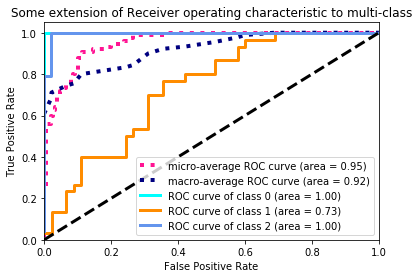

In [12]:
plt.figure()
lw = n_classes
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Precision Vs Recall

In [13]:
def plot_precision_recall_n(y_true, y_prob, model_name):
    from sklearn.metrics import precision_recall_curve
    y_score = y_prob
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylabel('precision', color='b')
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')

    name = model_name
    plt.title(name)
    #plt.savefig(name)
    plt.show()

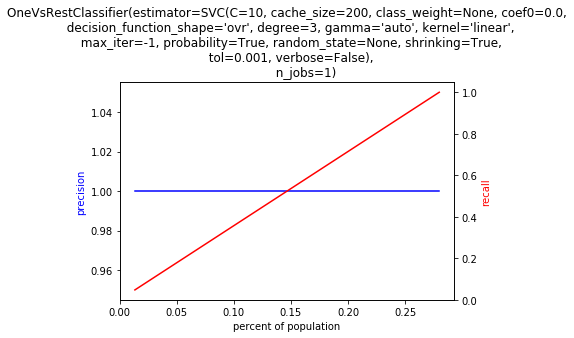

In [14]:
## no for multiclass labels

plot_precision_recall_n(y_test[:,0], y_score[:,0], classifier)

# From scikit learn

In [15]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.91


## Micro-average precision-recall curve

Text(0.5,1,'Average precision score, micro-averaged over all classes: AP=0.91')

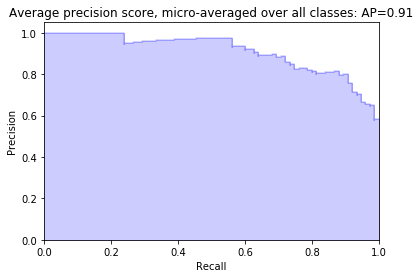

In [16]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

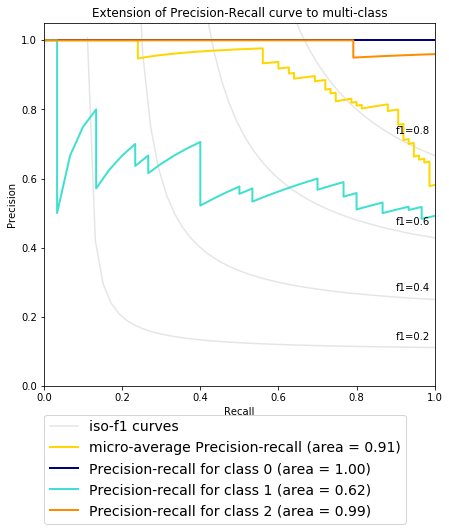

In [17]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()